In [1]:
import sys
import logging
import pickle
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
from joblib import hash, dump, load
import os

from deer.default_parser import process_args
from deer.agent import NeuralAgent
from deer.learning_algos.CRAR_torch import CRAR
import deer.controllers as bc
from deer.environments.Figure8 import MyEnv as Env

from deer.policies import EpsilonGreedyPolicy, FixedFigure8Policy

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
nn_yaml = 'dm'
internal_dim = 28
fname = 'test'
set_network = None #['expanded_tcm', 15, True]

In [17]:
engram_dir = '/mnt/smb/locker/aronov-locker/Ching/rl/'

In [11]:
class Defaults:
    # ----------------------
    # Setup Parameters (copied for convenience)
    # ----------------------
    figure8_give_rewards = True
    nn_yaml = nn_yaml
    high_dim_obs = False
    internal_dim = internal_dim
    fname = fname
    
    # ----------------------
    # Experiment Parameters
    # ----------------------
    steps_per_epoch = 2500
    epochs = 50
    steps_per_test = 1000
    period_btw_summary_perfs = 1

    # ----------------------
    # Temporal Processing Parameters
    # ----------------------
    mem_len = 3
    encoder_type = 'regular'
    
    # ----------------------
    # Environment Parameters
    # ----------------------
    frame_skip = 2
    show_rewards = False

    # ----------------------
    # DQN Agent parameters:
    # ----------------------
    learning_rate = 1*1E-4
    learning_rate_decay = 1.0
    discount = 0.9
    epsilon_start = 1.0
    epsilon_min = 1.0
    epsilon_decay = 1000
    update_frequency = 1
    replay_memory_size = 100000 #50000
    batch_size = 64
    freeze_interval = 1000
    deterministic = False
    
    # ----------------------
    # Learning algo parameters
    # ----------------------
    # T, entropy_neighbor, entropy_random, volume, gamma, R, Q, variational
    #loss_weights = [5E-3, 1E-3, 5E-3, 5E-3, 5E-3, 5E-3, 1.]
    loss_weights = [0, 0, 0, 0, 0, 0, 1., 0.]
    #loss_weights = [0., 0., 0., 0., 0., 0., 1., 2E-4]
    #loss_weights = [5E-3, 1E-3, 5E-3, 5E-3, 5E-3, 5E-3, 0., 0.]

In [12]:
parameters = Defaults()

In [20]:
if parameters.deterministic:
    rng = np.random.RandomState(123456)
else:
    rng = np.random.RandomState()

# --- Instantiate environment ---
env = Env(
    give_rewards=True,
    high_dim_obs=False,
    show_rewards=parameters.show_rewards
    )

# --- Instantiate learning_algo ---
learning_algo = CRAR(
    env,
    parameters.freeze_interval,
    parameters.batch_size,
    rng,
    internal_dim=internal_dim, lr=parameters.learning_rate,
    nn_yaml=nn_yaml, double_Q=True,
    loss_weights=parameters.loss_weights,
    mem_len=parameters.mem_len,
    encoder_type=parameters.encoder_type
    )


train_policy = EpsilonGreedyPolicy(
    learning_algo, env.nActions(), rng, 0.2,
    consider_valid_transitions=False
    )
test_policy = EpsilonGreedyPolicy(
    learning_algo, env.nActions(), rng, 0.
    )
    
# --- Instantiate agent ---
agent = NeuralAgent(
    env, learning_algo,
    parameters.replay_memory_size,
    1, parameters.batch_size, rng, save_dir=engram_dir,
    train_policy=train_policy, test_policy=test_policy)
if set_network is not None:
    agent.setNetwork(
        f'{set_network[0]}/fname', nEpoch=set_network[1],
        encoder_only=set_network[2]
        )

agent.run(10, 500)
print("end gathering data")

# --- Bind controllers to the agent ---
# Before every training epoch (periodicity=1), we want to print a summary of the agent's epsilon, discount and 
# learning rate as well as the training epoch number.
agent.attach(bc.VerboseController(
    evaluate_on='epoch', 
    periodicity=1))

# Learning rate may follow a scheduler
agent.attach(bc.LearningRateController(
    initial_learning_rate=parameters.learning_rate, 
    learning_rate_decay=parameters.learning_rate_decay,
    periodicity=1))

# During training epochs, we want to train the agent after every [parameters.update_frequency] action it takes.
# Plus, we also want to display after each training episode (!= than after every training) the average bellman
# residual and the average of the V values obtained during the last episode, hence the two last arguments.
agent.attach(bc.TrainerController(
    evaluate_on='action', 
    periodicity=parameters.update_frequency, 
    show_episode_avg_V_value=True, 
    show_avg_Bellman_residual=True))

# We wish to discover, among all versions of our neural network (i.e., after every training epoch), which one 
# has the highest validation score.
# To achieve this goal, one can use the FindBestController along with an InterleavedTestEpochControllers. It is 
# important that the validationID is the same than the id argument of the InterleavedTestEpochController.
# The FindBestController will dump on disk the validation scores for each and every network, as well as the 
# structure of the neural network having the best validation score. These dumps can then used to plot the evolution 
# of the validation and test scores (see below) or simply recover the resulting neural network for your 
# application.
agent.attach(bc.FindBestController(
    validationID=Env.VALIDATION_MODE,
    testID=None,
    unique_fname=fname, savefrequency=5))

# All previous controllers control the agent during the epochs it goes through. However, we want to interleave a 
# "validation epoch" between each training epoch. For each validation epoch, we want also to display the sum of all 
# rewards obtained, hence the showScore=True. Finally, we want to call the summarizePerformance method of ALE_env 
# every [parameters.period_btw_summary_perfs] *validation* epochs.
agent.attach(bc.InterleavedTestEpochController(
    id=Env.VALIDATION_MODE, 
    epoch_length=parameters.steps_per_test,
    periodicity=1,
    show_score=True,
    summarize_every=1,
    unique_fname=fname))

======= EPOCH 1: 0.4933648109436035 sec ======
======= EPOCH 2: 0.34018683433532715 sec ======
======= EPOCH 3: 0.36630821228027344 sec ======
======= EPOCH 4: 0.3585853576660156 sec ======
======= EPOCH 5: 0.3628878593444824 sec ======
======= EPOCH 6: 0.35817503929138184 sec ======
======= EPOCH 7: 0.33948349952697754 sec ======
======= EPOCH 8: 0.35417866706848145 sec ======
======= EPOCH 9: 0.34438395500183105 sec ======
======= EPOCH 10: 0.3423621654510498 sec ======
end gathering data


In [6]:
try:
    os.mkdir("params")
except Exception:
    pass
dump(vars(parameters), "params/" + fname + ".jldump")
#agent.gathering_data=False
if set_network is not None:
    agent.setNetwork(
        f'{set_network[0]}/fname', nEpoch=set_network[1],
        encoder_only=set_network[2]
        )
agent.run(parameters.epochs, parameters.steps_per_epoch)

# --- Show results ---
basename = "scores/" + fname
scores = load(basename + "_scores.jldump")
print(scores)

Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 0.0359, -0.2225,  0.3165,  0.1578,  0.2568,  0.0076, -0.0083,  0.3265,
        -0.0484,  0.0728]) tensor([ 0.1811, -0.0303,  0.0336,  0.3680, -0.1580, -0.2024,  0.1085,  0.1297,
        -0.1646, -0.2863]) tensor([ 0.0994, -0.2553,  0.2563,  0.0890,  0.3583, -0.0465, -0.0044,  0.3508,
        -0.1148,  0.0970])
R[0]
tensor([0.1647], grad_fn=<SelectBackward0>)
LOSSES
T = 0.058171156398952005; R = 0.015935857269912958;                 Gamma = 0.689298388838768; Q = 0.002145316639856901;
Entropy Neighbor = 0.7433496443033218;                 Entropy Random = 0.6659789493083954;                 Volume = 0.0; VAE = 0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 0.1715, -0.1128,  0.3757,  0.1519, -0.0440, -0.1954, -0.1946,  0.6030,
         0.4154,  0.0104]) tensor(

/Users/chingfang/miniforge3/envs/auxrl/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Testing score per episode (id: 0) is 0.0 (average over 1 episode(s))
== Mean score per episode is 0.0 over 1 episodes ==


/Users/chingfang/Code/deer/examples/test_CRAR/figure8_env.py:320: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_env.py:366: RuntimeWarning: invalid value encountered in divide
  dist_matrix = dist_matrix/np.nanpercentile(dist_matrix.flatten(), 99)
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_env.py:403: RuntimeWarning: All-NaN axis encountered
  ylim_max = np.nanmax(self._separability_tracking)*1.1


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([-0.1182,  0.0510,  0.0382,  0.0831, -0.0323, -0.1822, -0.1320,  0.1309,
         0.0105,  0.0749]) tensor([ 0.0282,  0.2775, -0.2436,  0.2987, -0.4537, -0.3863, -0.0272, -0.0367,
        -0.0836, -0.2879]) tensor([-0.1343,  0.0389,  0.0633,  0.1093, -0.0266, -0.1729, -0.1053,  0.1553,
         0.0451,  0.0736])
R[0]
tensor([0.1159], grad_fn=<SelectBackward0>)
LOSSES
T = 0.06037188592553139; R = 0.01337101586908102;                 Gamma = 0.7014917446374893; Q = 0.000675403090499458;
Entropy Neighbor = 0.7835826264619827;                 Entropy Random = 0.584825124502182;                 Volume = 0.00019380903616547583; VAE = 0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 0.0269,  0.0794,  0.1409,  0.1096, -0.0972, -0.0938, -0.1799,  0.0978,
         0.0031, 

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_env.py:320: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_env.py:366: RuntimeWarning: invalid value encountered in divide
  dist_matrix = dist_matrix/np.nanpercentile(dist_matrix.flatten(), 99)
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_env.py:403: RuntimeWarning: All-NaN axis encountered
  ylim_max = np.nanmax(self._separability_tracking)*1.1


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
2 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([-0.0117,  0.2413,  0.1072,  0.1659, -0.3579, -0.2274, -0.3962,  0.0732,
         0.0428,  0.1135]) tensor([ 0.1539,  0.5022, -0.1778,  0.4175, -0.7880, -0.4482, -0.3418, -0.0649,
        -0.0865, -0.2335]) tensor([-0.0080,  0.2447,  0.1053,  0.1745, -0.3523, -0.2258, -0.3826,  0.0673,
         0.0434,  0.1064])
R[0]
tensor([0.0761], grad_fn=<SelectBackward0>)
LOSSES
T = 0.06239106052368879; R = 0.01294782404974103;                 Gamma = 0.7138180400133133; Q = 0.0009408590035600355;
Entropy Neighbor = 0.8428135544061661;                 Entropy Random = 0.6704539647102356;                 Volume = 0.0020481328144669533; VAE = 0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 0.0131,  0.2170,  0.1392,  0.1697, -0.3892, -0.2042, -0.4021,  0.0640,
         0.0562,

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_env.py:320: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_env.py:366: RuntimeWarning: invalid value encountered in divide
  dist_matrix = dist_matrix/np.nanpercentile(dist_matrix.flatten(), 99)
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_env.py:403: RuntimeWarning: All-NaN axis encountered
  ylim_max = np.nanmax(self._separability_tracking)*1.1


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
2 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 0.0943,  0.2804,  0.1511,  0.2016, -0.3967, -0.2029, -0.3867,  0.0124,
         0.1090,  0.0925]) tensor([ 0.2594,  0.5367, -0.1355,  0.4488, -0.8239, -0.4251, -0.3298, -0.1265,
        -0.0247, -0.2554]) tensor([ 0.1018,  0.2898,  0.1600,  0.2079, -0.3763, -0.1905, -0.3653,  0.0061,
         0.1096,  0.0917])
R[0]
tensor([0.0751], grad_fn=<SelectBackward0>)
LOSSES
T = 0.06273420323431492; R = 0.011617353445850312;                 Gamma = 0.7194670553207397; Q = 0.0006751020355441142;
Entropy Neighbor = 0.8411960542201996;                 Entropy Random = 0.6372062109708786;                 Volume = 0.0015386807769536973; VAE = 0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 0.0712,  0.3117,  0.1513,  0.2001, -0.4011, -0.2293, -0.4490,  0.0395,
         0.0754

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_env.py:268: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:204.)
  torch.as_tensor([action_encoding]).to(device)
/Users/chingfang/Code/deer/examples/test_CRAR/figure8_env.py:320: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
2 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 0.0862,  0.3218,  0.1659,  0.2188, -0.4261, -0.2309, -0.4521,  0.0453,
         0.0886,  0.1107]) tensor([ 0.2514,  0.5783, -0.1210,  0.4653, -0.8531, -0.4533, -0.3953, -0.0922,
        -0.0472, -0.2373]) tensor([ 0.0781,  0.3371,  0.1835,  0.2206, -0.4203, -0.2194, -0.4624,  0.0465,
         0.0793,  0.1172])
R[0]
tensor([0.0714], grad_fn=<SelectBackward0>)
LOSSES
T = 0.06627194117754698; R = 0.015919183759950103;                 Gamma = 0.7198234907388688; Q = 0.002464969843160361;
Entropy Neighbor = 0.678620010137558;                 Entropy Random = 0.3696032619476318;                 Volume = 0.0034313320443034173; VAE = 0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 0.2023,  0.3779,  0.2256,  0.2845, -0.4296, -0.1868, -0.3937,  0.0097,
         0.1845, 

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_env.py:320: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 1.0
Es[0], TEs[0], Esp_[0]
tensor([-0.0220,  0.2699,  0.2421,  0.0979, -0.3401, -0.1660, -0.5170,  0.1697,
        -0.0412,  0.1313]) tensor([ 0.1267,  0.4967, -0.0421,  0.3143, -0.7614, -0.3706, -0.4166,  0.0117,
        -0.1517, -0.2310]) tensor([-0.0066,  0.2835,  0.2525,  0.0945, -0.3115, -0.1585, -0.5059,  0.1804,
        -0.0369,  0.1270])
R[0]
tensor([0.0986], grad_fn=<SelectBackward0>)
LOSSES
T = 0.07285787776857615; R = 0.023396272771060468;                 Gamma = 0.7183314474821091; Q = 0.002355642563547008;
Entropy Neighbor = 0.5471491819024086;                 Entropy Random = 0.169674096763134;                 Volume = 0.005264438662678003; VAE = 0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 0.0249,  0.3139,  0.2976,  0.0991, -0.3465, -0.1520, -0.5289,  0.2027,
        -0.0172,  

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_env.py:320: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
2 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([-0.0474,  0.1160,  0.1199,  0.0952, -0.0529, -0.1407, -0.2965,  0.1672,
        -0.0609,  0.1051]) tensor([ 0.1168,  0.3746, -0.1649,  0.3504, -0.4856, -0.3592, -0.2417,  0.0235,
        -0.1806, -0.2429]) tensor([-0.2384,  0.0349,  0.1422,  0.0345, -0.1720, -0.1292, -0.4082,  0.1874,
        -0.1829,  0.1675])
R[0]
tensor([0.0827], grad_fn=<SelectBackward0>)
LOSSES
T = 0.07526154637336731; R = 0.03142352532222867;                 Gamma = 0.7138921304941177; Q = 0.003425708547816612;
Entropy Neighbor = 0.472198095202446;                 Entropy Random = 0.12081430124491453;                 Volume = 0.007926449485123157; VAE = 0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 0.0887,  0.1770,  0.1250,  0.1372, -0.0490, -0.1494, -0.1896,  0.1501,
         0.0831,  

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_env.py:320: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 0.0547,  0.2873,  0.2274,  0.1551, -0.3249, -0.1563, -0.4074,  0.1054,
         0.0913,  0.1071]) tensor([ 0.1997,  0.5155, -0.0578,  0.3668, -0.7374, -0.3729, -0.3232, -0.0275,
        -0.0558, -0.2518]) tensor([ 0.1044,  0.3185,  0.2424,  0.1908, -0.3346, -0.1529, -0.3921,  0.0859,
         0.1189,  0.1005])
R[0]
tensor([0.0604], grad_fn=<SelectBackward0>)
LOSSES
T = 0.07788006852567196; R = 0.038441196633502844;                 Gamma = 0.7126074876785279; Q = 0.0022373276885482483;
Entropy Neighbor = 0.45618480747938156;                 Entropy Random = 0.12405283932387828;                 Volume = 0.011944755986332893; VAE = 0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
2 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 0.0778,  0.2109,  0.1304,  0.1690,  0.1548, -0.1083, -0.0743,  0.1856,
         0.079

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_env.py:320: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([-0.0827,  0.2067,  0.1498,  0.0349,  0.0534, -0.0952, -0.2507,  0.2067,
        -0.0470,  0.0984]) tensor([ 0.0650,  0.4294, -0.1346,  0.2515, -0.3682, -0.3002, -0.1486,  0.0401,
        -0.1482, -0.2636]) tensor([-0.0827,  0.2067,  0.1498,  0.0349,  0.0534, -0.0952, -0.2507,  0.2067,
        -0.0470,  0.0984])
R[0]
tensor([0.1094], grad_fn=<SelectBackward0>)
LOSSES
T = 0.08064424785971641; R = 0.04247652554884553;                 Gamma = 0.713564034819603; Q = 0.0027273431858047844;
Entropy Neighbor = 0.43740156131982805;                 Entropy Random = 0.13537940408289434;                 Volume = 0.014784607514739036; VAE = 0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 0.0225,  0.3011,  0.2085,  0.1560, -0.1900, -0.1365, -0.3067,  0.1300,
         0.0721,

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_env.py:320: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 1.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 0.0730, -0.4412,  0.0586, -0.2489,  0.9045, -0.1004,  0.3017,  0.7530,
        -0.2029, -0.1215]) tensor([ 0.2018, -0.2292, -0.2181, -0.0440,  0.4857, -0.3037,  0.4072,  0.5836,
        -0.3047, -0.4869]) tensor([ 0.1732,  0.2941,  0.2045,  0.1195,  0.0908, -0.1155, -0.0858,  0.2371,
         0.1706,  0.0682])
R[0]
tensor([0.0936], grad_fn=<SelectBackward0>)
LOSSES
T = 0.08324918159842491; R = 0.04796348936110735;                 Gamma = 0.7149710056781768; Q = 0.001966897225996945;
Entropy Neighbor = 0.4162300279736519;                 Entropy Random = 0.12573074480891228;                 Volume = 0.0169328679703176; VAE = 0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 0.1370,  0.3002,  0.2215,  0.1662,  0.1502, -0.0847, -0.0294,  0.2313,
         0.1364,  0

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_env.py:320: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([-0.2376, -0.2247,  0.4780,  0.3291,  0.9100,  0.4314,  0.4546,  0.0783,
        -0.5569,  0.1549]) tensor([-0.0964, -0.0100,  0.1955,  0.5571,  0.4904,  0.2203,  0.5483, -0.0963,
        -0.6460, -0.2060]) tensor([-0.1624, -0.1465,  0.3157,  0.3360,  0.4965,  0.1477,  0.3405,  0.1392,
        -0.1517,  0.2060])
R[0]
tensor([0.1168], grad_fn=<SelectBackward0>)
LOSSES
T = 0.08575585988163949; R = 0.05372972232662141;                 Gamma = 0.7147860589027405; Q = 0.002391118438448757;
Entropy Neighbor = 0.3961644852757454;                 Entropy Random = 0.10986386201530694;                 Volume = 0.0220870842076838; VAE = 0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([-0.0501,  0.2730,  0.2449,  0.0520, -0.0345, -0.0645, -0.2776,  0.2136,
         0.0045,  0

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_env.py:320: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
2 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([-4.4794e-02,  3.4715e-01,  3.4513e-01,  1.3738e-01,  1.2825e-01,
         1.7963e-04, -1.2687e-01,  2.5663e-01, -1.3194e-03,  8.6827e-02]) tensor([ 0.1180,  0.5934,  0.0576,  0.3870, -0.3034, -0.2186, -0.0674,  0.1036,
        -0.1249, -0.2614]) tensor([-0.1936,  0.2782,  0.2635,  0.0516,  0.1055, -0.0353, -0.1907,  0.2716,
        -0.1154,  0.1000])
R[0]
tensor([0.0899], grad_fn=<SelectBackward0>)
LOSSES
T = 0.08740072514116765; R = 0.05505685520917177;                 Gamma = 0.7154669815301895; Q = 0.0019999766182736494;
Entropy Neighbor = 0.3923661119937897;                 Entropy Random = 0.11066897106170655;                 Volume = 0.02683261024579406; VAE = 0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 0.2146,  0.3739,  0.3402,  0.1756,  0.3741, -0.0

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_env.py:320: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
2 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([-0.1410,  0.3314,  0.3244,  0.0641,  0.0911, -0.0147, -0.1755,  0.2983,
        -0.0714,  0.0942]) tensor([ 0.0230,  0.5847,  0.0394,  0.3198, -0.3446, -0.2318, -0.1201,  0.1474,
        -0.1920, -0.2522]) tensor([-0.2834,  0.2040,  0.2779,  0.0178,  0.0573, -0.0083, -0.2287,  0.2873,
        -0.1929,  0.1152])
R[0]
tensor([0.0898], grad_fn=<SelectBackward0>)
LOSSES
T = 0.08957477414608002; R = 0.060139070477336645;                 Gamma = 0.7158863199949265; Q = 0.0018517279022489674;
Entropy Neighbor = 0.38451024508476256;                 Entropy Random = 0.110325279019773;                 Volume = 0.034294454660266635; VAE = 0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([-0.0817,  0.3144,  0.2666,  0.0431,  0.0681, -0.0744, -0.1881,  0.3183,
        -0.0038,

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_env.py:320: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
2 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([-0.4254,  0.0733,  0.2578, -0.0122,  0.2691,  0.0426, -0.0853,  0.3557,
        -0.3730,  0.0855]) tensor([-0.2600,  0.3414, -0.0209,  0.2598, -0.1760, -0.1691, -0.0358,  0.2029,
        -0.4709, -0.2588]) tensor([-0.2976, -0.2098,  0.2939,  0.1685,  0.4811,  0.1959,  0.2401,  0.1573,
        -0.3471,  0.2394])
R[0]
tensor([0.1045], grad_fn=<SelectBackward0>)
LOSSES
T = 0.090015646353364; R = 0.06011982501670718;                 Gamma = 0.7156246424913406; Q = 0.0019575851927511392;
Entropy Neighbor = 0.37122128933668136;                 Entropy Random = 0.10889028517156839;                 Volume = 0.03579046378284693; VAE = 0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
2 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([-0.0880, -0.0552,  0.1369, -0.1752,  0.3710, -0.0756,  0.0179,  0.5288,
        -0.0714, -

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_env.py:320: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([-0.0293,  0.3811,  0.3065,  0.0737,  0.0435, -0.0636, -0.1828,  0.3034,
         0.0045,  0.0596]) tensor([ 0.1169,  0.5957,  0.0212,  0.2824, -0.3760, -0.2693, -0.0756,  0.1312,
        -0.1040, -0.3026]) tensor([-0.0922,  0.3057,  0.2702,  0.0389,  0.0296, -0.0779, -0.1918,  0.3211,
        -0.0129,  0.0825])
R[0]
tensor([0.1127], grad_fn=<SelectBackward0>)
LOSSES
T = 0.09160853190720081; R = 0.06372781167551875;                 Gamma = 0.7152248524427414; Q = 0.002165144625119865;
Entropy Neighbor = 0.35778139543533327;                 Entropy Random = 0.10248285053670406;                 Volume = 0.03753773126006126; VAE = 0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 0.0307,  0.2759,  0.2659,  0.0871,  0.2339, -0.0373,  0.0143,  0.3054,
         0.0622, 

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_env.py:320: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([0.2187, 0.1248, 0.3742, 0.1467, 0.6552, 0.0533, 0.4064, 0.4301, 0.1116,
        0.0547]) tensor([ 0.3544,  0.3083,  0.0874,  0.3300,  0.2467, -0.1538,  0.5395,  0.2276,
         0.0111, -0.3138]) tensor([ 0.0450, -0.2536,  0.1607,  0.0796,  0.7494, -0.0161,  0.4764,  0.5000,
        -0.0026, -0.0096])
R[0]
tensor([0.1384], grad_fn=<SelectBackward0>)
LOSSES
T = 0.09163985304534435; R = 0.06512743949890137;                 Gamma = 0.7154088206291199; Q = 0.0022392483010771685;
Entropy Neighbor = 0.3582841964364052;                 Entropy Random = 0.10630823995172978;                 Volume = 0.04079713187739253; VAE = 0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 0.0110, -0.1431,  0.3329,  0.2341,  0.7354,  0.1317,  0.5567,  0.3410,
        -0.0411,  0.1389]) 

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_env.py:320: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 1.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([-0.1468, -0.4940,  0.1700, -0.2885,  1.0793,  0.0917,  0.4288,  0.7533,
        -0.4738, -0.0836]) tensor([-0.0155, -0.2732, -0.1023, -0.0667,  0.6512, -0.1073,  0.5282,  0.5787,
        -0.5574, -0.4458]) tensor([-0.0256,  0.2773,  0.3286,  0.0445,  0.1156, -0.0194, -0.0420,  0.3242,
         0.0144,  0.0948])
R[0]
tensor([0.1086], grad_fn=<SelectBackward0>)
LOSSES
T = 0.0928132323473692; R = 0.0673449031971395;                 Gamma = 0.7152611376047134; Q = 0.0030025651350733826;
Entropy Neighbor = 0.35531657564640046;                 Entropy Random = 0.1073349967226386;                 Volume = 0.04333573320508003; VAE = 0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([-0.3489, -0.2365,  0.2473,  0.0981,  0.5214,  0.1241,  0.2270,  0.3033,
        -0.3964,  0

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_env.py:320: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
2 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([-0.2467,  0.2540,  0.2886,  0.0119,  0.1274, -0.0143, -0.1275,  0.3429,
        -0.1514,  0.0718]) tensor([-0.0823,  0.5134,  0.0065,  0.2730, -0.3121, -0.2293, -0.0744,  0.1911,
        -0.2647, -0.2733]) tensor([-0.2940,  0.2322,  0.3273,  0.0088,  0.2191,  0.0476, -0.0792,  0.3612,
        -0.2471,  0.0594])
R[0]
tensor([0.0951], grad_fn=<SelectBackward0>)
LOSSES
T = 0.09359251753985882; R = 0.06906657340750098;                 Gamma = 0.715354007601738; Q = 0.00274514488899149;
Entropy Neighbor = 0.3434087598025799;                 Entropy Random = 0.10373649463802576;                 Volume = 0.0440928051173687; VAE = 0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([-0.3025, -0.1886,  0.3410,  0.1130,  0.5334,  0.1875,  0.2423,  0.2937,
        -0.3895,  0.1

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_env.py:320: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([0.0986, 0.2674, 0.3869, 0.1401, 0.4519, 0.0175, 0.2588, 0.4169, 0.0905,
        0.0365]) tensor([ 0.2375,  0.4602,  0.1007,  0.3310,  0.0394, -0.1887,  0.3843,  0.2228,
        -0.0125, -0.3296]) tensor([0.2350, 0.0933, 0.4108, 0.2046, 0.6489, 0.0632, 0.4520, 0.4370, 0.1122,
        0.0490])
R[0]
tensor([0.1330], grad_fn=<SelectBackward0>)
LOSSES
T = 0.09375425714254379; R = 0.06995314163714647;                 Gamma = 0.7152017886638642; Q = 0.002564889285597019;
Entropy Neighbor = 0.3396524333357811;                 Entropy Random = 0.10539207055419683;                 Volume = 0.041674312934279444; VAE = 0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 0.0545, -0.2359,  0.1961,  0.1216,  0.6246, -0.0420,  0.4612,  0.5129,
         0.1053,  0.0026]) tensor([ 0

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_env.py:320: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 0.0953, -0.1526,  0.5747,  0.2477,  0.8829,  0.3920,  0.5591,  0.2101,
        -0.3017,  0.2428]) tensor([ 0.2386,  0.0195,  0.2903,  0.4505,  0.4741,  0.1768,  0.6869, -0.0135,
        -0.4082, -0.1155]) tensor([-0.2921, -0.0646,  0.7176,  0.2496,  1.2933,  0.6692,  0.4488,  0.2243,
        -1.0019, -0.0663])
R[0]
tensor([0.1890], grad_fn=<SelectBackward0>)
LOSSES
T = 0.094033795773983; R = 0.07088561379350722;                 Gamma = 0.7158965791463852; Q = 0.0027461018555914054;
Entropy Neighbor = 0.33812506529688835;                 Entropy Random = 0.10363047837466001;                 Volume = 0.040318491775542496; VAE = 0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([-0.2896, -0.1395,  0.4221,  0.2134,  0.2830,  0.1873,  0.1424,  0.1782,
        -0.3136, 

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_env.py:320: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([0.1191, 0.2327, 0.4071, 0.1322, 0.5097, 0.0369, 0.3115, 0.4481, 0.0851,
        0.0485]) tensor([ 0.2529,  0.4276,  0.1196,  0.3241,  0.1021, -0.1772,  0.4189,  0.2794,
        -0.0476, -0.3163]) tensor([0.1684, 0.0242, 0.3815, 0.2330, 0.6541, 0.0810, 0.4923, 0.3942, 0.1063,
        0.0805])
R[0]
tensor([0.0941], grad_fn=<SelectBackward0>)
LOSSES
T = 0.09454524087905884; R = 0.07240386892855168;                 Gamma = 0.7159579560756684; Q = 0.0024626867200713606;
Entropy Neighbor = 0.33312729600071905;                 Entropy Random = 0.10622434099018574;                 Volume = 0.04244926869124174; VAE = 0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([-0.2357,  0.1815,  0.2715,  0.0580,  0.0776,  0.0082, -0.1447,  0.2614,
        -0.1529,  0.1059]) tensor([-

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_env.py:320: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 0.0585,  0.4124,  0.3669,  0.0835,  0.1511, -0.0303, -0.0521,  0.3637,
         0.0672, -0.0005]) tensor([ 0.2024,  0.6181,  0.0806,  0.2839, -0.2653, -0.2369,  0.0614,  0.1845,
        -0.0440, -0.3636]) tensor([-0.0040,  0.3514,  0.3685,  0.1055,  0.2866,  0.0163,  0.1007,  0.3545,
         0.0029,  0.0394])
R[0]
tensor([0.1178], grad_fn=<SelectBackward0>)
LOSSES
T = 0.09563979966938496; R = 0.0731341240555048;                 Gamma = 0.7160592782497406; Q = 0.002638033454364631;
Entropy Neighbor = 0.32878244504332543;                 Entropy Random = 0.10492424493283034;                 Volume = 0.04308195370435715; VAE = 0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([-0.1187, -0.2500,  0.2105, -0.1226,  0.7225,  0.0290,  0.3211,  0.6786,
        -0.2818, -

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_env.py:320: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 0.1214,  0.2608,  0.3400,  0.1083,  0.3359, -0.0203,  0.2230,  0.3954,
         0.1117,  0.0631]) tensor([ 0.2603,  0.4557,  0.0545,  0.2992, -0.0770, -0.2260,  0.3481,  0.2035,
         0.0074, -0.3030]) tensor([0.0118, 0.2136, 0.3943, 0.0917, 0.4453, 0.0375, 0.2687, 0.4562, 0.0080,
        0.0447])
R[0]
tensor([0.1312], grad_fn=<SelectBackward0>)
LOSSES
T = 0.09581183077394963; R = 0.07464368018694222;                 Gamma = 0.7162871272563934; Q = 0.0027987168052932246;
Entropy Neighbor = 0.32326050561666486;                 Entropy Random = 0.10249333132058382;                 Volume = 0.043152062576264145; VAE = 0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 0.1754,  0.2476,  0.3501,  0.1787,  0.2747, -0.0463,  0.2104,  0.3788,
         0.2190,  0.0799]

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_env.py:320: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 0.1628,  0.2327,  0.3393,  0.0920,  0.3204, -0.0560,  0.2263,  0.4409,
         0.1920,  0.0682]) tensor([ 0.2998,  0.4231,  0.0533,  0.2783, -0.0910, -0.2610,  0.3549,  0.2478,
         0.0854, -0.2995]) tensor([0.1408, 0.1418, 0.3510, 0.0998, 0.4886, 0.0254, 0.3461, 0.4187, 0.0776,
        0.0897])
R[0]
tensor([0.1306], grad_fn=<SelectBackward0>)
LOSSES
T = 0.09671420070528984; R = 0.0763650903068483;                 Gamma = 0.7164934743642807; Q = 0.0027068144569639117;
Entropy Neighbor = 0.32161142900586126;                 Entropy Random = 0.1029815871566534;                 Volume = 0.04456492119282484; VAE = 0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 0.4516,  0.0263,  0.3451,  0.3035,  0.4095, -0.0598,  0.4897,  0.3349,
         0.4679,  0.1344]) t

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_env.py:320: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 1.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([-0.1137,  0.1086,  0.7915,  0.3121,  1.1510,  0.6652,  0.3430,  0.1204,
        -0.7878,  0.0099]) tensor([ 0.0410,  0.3003,  0.5060,  0.5388,  0.7349,  0.4440,  0.4466, -0.0925,
        -0.8932, -0.3393]) tensor([ 0.0429,  0.3624,  0.3738,  0.1146,  0.1274, -0.0229, -0.0337,  0.3582,
         0.0425,  0.0124])
R[0]
tensor([0.1782], grad_fn=<SelectBackward0>)
LOSSES
T = 0.0965839336514473; R = 0.0770751284006983;                 Gamma = 0.7166262555122376; Q = 0.0028202170585282147;
Entropy Neighbor = 0.31727783191204073;                 Entropy Random = 0.10363354633748531;                 Volume = 0.04314151947945356; VAE = 0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([-0.1629,  0.3165,  0.3451,  0.0407,  0.1252, -0.0031, -0.0591,  0.3641,
        -0.0860,  

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_env.py:320: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([-0.3115,  0.2625,  0.3031,  0.0363,  0.1482,  0.0019, -0.0599,  0.3399,
        -0.1943,  0.1110]) tensor([-0.1576,  0.4787,  0.0235,  0.2651, -0.2767, -0.2101,  0.0355,  0.1548,
        -0.3147, -0.2386]) tensor([-0.2952,  0.2620,  0.3237,  0.0569,  0.1622,  0.0219, -0.0455,  0.3354,
        -0.1984,  0.1041])
R[0]
tensor([0.1619], grad_fn=<SelectBackward0>)
LOSSES
T = 0.09737267838418484; R = 0.07736089568212628;                 Gamma = 0.7164309461116791; Q = 0.0028458326215622947;
Entropy Neighbor = 0.31482062140107153;                 Entropy Random = 0.1029261894673109;                 Volume = 0.04689262790977955; VAE = 0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
2 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([0.0998, 0.3581, 0.4029, 0.1550, 0.3096, 0.0135, 0.1667, 0.3677, 0.1010,
        0.0418]) 

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_env.py:320: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([-0.0074,  0.3697,  0.4057,  0.0838,  0.1658,  0.0094, -0.0084,  0.3740,
         0.0008,  0.0327]) tensor([ 0.1331,  0.5850,  0.1209,  0.2910, -0.2486, -0.2052,  0.0830,  0.2213,
        -0.1376, -0.3266]) tensor([-0.0173,  0.3585,  0.3762,  0.0974,  0.1737,  0.0019,  0.0167,  0.3527,
         0.0126,  0.0431])
R[0]
tensor([0.0821], grad_fn=<SelectBackward0>)
LOSSES
T = 0.097913829728961; R = 0.07896172466501594;                 Gamma = 0.7171174031496048; Q = 0.003141417372622527;
Entropy Neighbor = 0.3118745744228363;                 Entropy Random = 0.10319382036477327;                 Volume = 0.0465340959765017; VAE = 0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 0.0009, -0.1144,  0.3825,  0.2072,  0.6909,  0.1633,  0.5468,  0.3523,
        -0.1240,  0.1

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_env.py:320: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([-0.0249,  0.2549,  0.3618,  0.0660,  0.1174,  0.0182, -0.0098,  0.3070,
        -0.0116,  0.1025]) tensor([ 0.1154,  0.4722,  0.0781,  0.2767, -0.2986, -0.1943,  0.0817,  0.1548,
        -0.1444, -0.2575]) tensor([0.0927, 0.3385, 0.3823, 0.0705, 0.1550, 0.0042, 0.0546, 0.3070, 0.0839,
        0.1066])
R[0]
tensor([0.0843], grad_fn=<SelectBackward0>)
LOSSES
T = 0.09832886618375779; R = 0.08115587286651134;                 Gamma = 0.7170143597126007; Q = 0.003098883578495588;
Entropy Neighbor = 0.31071510967612265;                 Entropy Random = 0.10001061183959245;                 Volume = 0.04810501665621996; VAE = 0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([-0.0534, -0.2453,  0.2552,  0.2031,  0.6003,  0.0368,  0.4755,  0.4402,
        -0.0355,  0.0379]) 

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_env.py:320: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
2 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([-0.1402,  0.3186,  0.3390,  0.0812,  0.0887, -0.0061, -0.0889,  0.3289,
        -0.0983,  0.0711]) tensor([ 0.0230,  0.5720,  0.0553,  0.3358, -0.3474, -0.2227, -0.0316,  0.1744,
        -0.2165, -0.2751]) tensor([-0.2392,  0.3372,  0.3546,  0.0455,  0.1283,  0.0190, -0.0854,  0.3516,
        -0.1730,  0.0627])
R[0]
tensor([0.0950], grad_fn=<SelectBackward0>)
LOSSES
T = 0.09765427468717099; R = 0.08084253751859069;                 Gamma = 0.7169969222545624; Q = 0.002890373047150206;
Entropy Neighbor = 0.3103393856883049;                 Entropy Random = 0.10128897356241942;                 Volume = 0.044063201200217006; VAE = 0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([-0.2586, -0.1162,  0.4295,  0.0987,  0.4865,  0.2169,  0.2541,  0.3357,
        -0.3465, 

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_env.py:320: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 0.0293,  0.3386,  0.3436,  0.0975,  0.2069, -0.0067,  0.0551,  0.3362,
         0.0391,  0.0512]) tensor([ 0.1723,  0.5437,  0.0584,  0.2986, -0.2100, -0.2123,  0.1707,  0.1531,
        -0.0659, -0.3124]) tensor([ 0.0845,  0.3114,  0.3698,  0.1031,  0.3071, -0.0007,  0.1682,  0.3725,
         0.0816,  0.0651])
R[0]
tensor([0.1248], grad_fn=<SelectBackward0>)
LOSSES
T = 0.0987057785987854; R = 0.0817191520743072;                 Gamma = 0.7172244929075241; Q = 0.003453870644210838;
Entropy Neighbor = 0.30834140461683274;                 Entropy Random = 0.10108684765547514;                 Volume = 0.04707583542913198; VAE = 0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 0.2044,  0.1611,  0.3101,  0.1205,  0.3314, -0.0698,  0.3021,  0.4281,
         0.2498,  0

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_env.py:320: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
2 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([-0.2774,  0.2922,  0.3198,  0.0301,  0.1563, -0.0011, -0.0429,  0.3647,
        -0.1689,  0.0948]) tensor([-0.1136,  0.5505,  0.0382,  0.2904, -0.2836, -0.2155,  0.0118,  0.2097,
        -0.2802, -0.2504]) tensor([-0.2995,  0.2915,  0.3691,  0.0221,  0.2112,  0.0605, -0.0472,  0.3798,
        -0.2407,  0.0508])
R[0]
tensor([0.0996], grad_fn=<SelectBackward0>)
LOSSES
T = 0.0986839664876461; R = 0.08013889997825027;                 Gamma = 0.7167694953680038; Q = 0.0032750839094514957;
Entropy Neighbor = 0.3056538131535053;                 Entropy Random = 0.1015729507431388;                 Volume = 0.045583044186234475; VAE = 0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([-0.0409,  0.3709,  0.3914,  0.0545,  0.1749,  0.0179,  0.0212,  0.3492,
        -0.0199,  

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_env.py:320: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([-0.2849,  0.1584,  0.2709,  0.0604,  0.0468, -0.0063, -0.1420,  0.2855,
        -0.1782,  0.1191]) tensor([-0.1373,  0.3862, -0.0093,  0.2857, -0.3819, -0.2063, -0.0409,  0.1138,
        -0.2670, -0.2416]) tensor([-0.1592,  0.2813,  0.3298,  0.0187, -0.0030, -0.0382, -0.1753,  0.3550,
        -0.0828,  0.0823])
R[0]
tensor([0.1257], grad_fn=<SelectBackward0>)
LOSSES
T = 0.09895063363015652; R = 0.07981426366046071;                 Gamma = 0.7166433475017547; Q = 0.00358382836706005;
Entropy Neighbor = 0.3044057426154613;                 Entropy Random = 0.10252796851098538;                 Volume = 0.04786895842477679; VAE = 0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
2 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([-0.0416,  0.4042,  0.3946,  0.0379,  0.0390, -0.0145, -0.1596,  0.3649,
        -0.0273,  0

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_env.py:320: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([0.0099, 0.3153, 0.3659, 0.1087, 0.2987, 0.0079, 0.1799, 0.3665, 0.0390,
        0.0955]) tensor([ 0.1510,  0.5162,  0.0812,  0.3072, -0.1177, -0.1968,  0.2998,  0.1776,
        -0.0623, -0.2690]) tensor([0.0476, 0.2663, 0.3822, 0.1237, 0.4309, 0.0305, 0.3001, 0.4169, 0.0394,
        0.0868])
R[0]
tensor([0.1317], grad_fn=<SelectBackward0>)
LOSSES
T = 0.09937259212136268; R = 0.08074065243452787;                 Gamma = 0.7178631558418274; Q = 0.0028171943015768194;
Entropy Neighbor = 0.30263017109036444;                 Entropy Random = 0.10058434956520795;                 Volume = 0.047569659307599065; VAE = 0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([0.1050, 0.2448, 0.3769, 0.1131, 0.4419, 0.0037, 0.3275, 0.4647, 0.0847,
        0.0486]) tensor([ 0.2387,  

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_env.py:320: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
2 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([-0.2862,  0.2951,  0.3262,  0.0428,  0.1487,  0.0122, -0.0470,  0.3444,
        -0.1766,  0.0971]) tensor([-0.1220,  0.5539,  0.0445,  0.3041, -0.2913, -0.2024,  0.0071,  0.1898,
        -0.2878, -0.2479]) tensor([-0.3389,  0.2473,  0.3531,  0.0213,  0.2264,  0.0584, -0.0174,  0.3873,
        -0.2621,  0.0700])
R[0]
tensor([0.1001], grad_fn=<SelectBackward0>)
LOSSES
T = 0.09976053594052792; R = 0.08183151984214783;                 Gamma = 0.7167328095436096; Q = 0.004217548418324441;
Entropy Neighbor = 0.2972580508291721;                 Entropy Random = 0.09989809389784932;                 Volume = 0.047710428781807424; VAE = 0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
2 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([-0.3048,  0.2981,  0.3320,  0.0289,  0.1590,  0.0151, -0.0636,  0.3602,
        -0.2123, 

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_env.py:320: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
1 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 1.1712e-04,  8.2101e-02,  2.5868e-01,  6.0526e-02,  1.8483e-01,
        -3.1256e-02,  1.2599e-01,  3.5369e-01,  1.0090e-01,  9.9010e-02]) tensor([ 0.1366,  0.2934, -0.0248,  0.2652, -0.2294, -0.2417,  0.2246,  0.1965,
        -0.0272, -0.2639]) tensor([-0.4940, -0.4326, -0.1079,  0.0480, -0.0572, -0.1466,  0.0023,  0.2146,
        -0.1849,  0.1515])
R[0]
tensor([0.0908], grad_fn=<SelectBackward0>)
LOSSES
T = 0.09997751231491565; R = 0.08319425443559884;                 Gamma = 0.7170494999885559; Q = 0.004402962254651356;
Entropy Neighbor = 0.3006095194518566;                 Entropy Random = 0.10175308519601822;                 Volume = 0.04959225368499756; VAE = 0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 0.4544, -0.0562,  0.3094,  0.2533,  0.3761, -0.09

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_env.py:320: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([-0.1052, -0.1587,  0.2796,  0.1180,  0.6291,  0.0534,  0.4401,  0.4956,
        -0.1199,  0.0304]) tensor([ 3.7895e-02,  3.1473e-02,  2.5403e-04,  3.2462e-01,  2.1288e-01,
        -1.5733e-01,  5.6115e-01,  2.8208e-01, -2.2633e-01, -3.2617e-01]) tensor([-0.1818, -0.1876,  0.1957,  0.1214,  0.6138,  0.0454,  0.4306,  0.4427,
        -0.1810, -0.0103])
R[0]
tensor([0.1860], grad_fn=<SelectBackward0>)
LOSSES
T = 0.10077220456302166; R = 0.08638393099233509;                 Gamma = 0.7176505808830261; Q = 0.0040960134541383015;
Entropy Neighbor = 0.29477955934405325;                 Entropy Random = 0.10055364229530096;                 Volume = 0.050850992772728205; VAE = 0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
3 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([ 0.0274,  0.1747,  0.4544,  0.1425,  0.5620,  0

/Users/chingfang/Code/deer/examples/test_CRAR/figure8_env.py:320: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
2 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([-0.3435,  0.1553,  0.4260,  0.0034,  0.2907,  0.1564,  0.0185,  0.3769,
        -0.3444,  0.0965]) tensor([-0.1802,  0.4142,  0.1465,  0.2709, -0.1538, -0.0543,  0.0732,  0.2169,
        -0.4444, -0.2485]) tensor([-0.2535, -0.0713,  0.4425,  0.1111,  0.4771,  0.2153,  0.2541,  0.3408,
        -0.3580,  0.1952])
R[0]
tensor([0.1103], grad_fn=<SelectBackward0>)
LOSSES
T = 0.1004647610783577; R = 0.08343044790253043;                 Gamma = 0.7171525371074676; Q = 0.004416846320731566;
Entropy Neighbor = 0.294104270786047;                 Entropy Random = 0.1014782331287861;                 Volume = 0.04861234221607447; VAE = 0.0
Printing a few elements useful for debugging:
actions_val[0], rewards_val[0], terminals_val[0]
0 0.0 0.0
Es[0], TEs[0], Esp_[0]
tensor([0.0589, 0.3270, 0.4028, 0.1434, 0.3096, 0.0070, 0.1629, 0.4045, 0.0948,
        0.0339]) tens


KeyboardInterrupt



In [ ]:
agent._learning_algo.device

## Visualize performance

In [23]:
agent.setNetwork(f'altT_dm_dim28/altT_mb_0/fname', nEpoch=40)

In [24]:
agent._in_episode = True
agent._mode = 0 # Testing mode with plan_depth=0
initState = env.reset(agent._mode)
inputDims = env.inputDimensions()

for i in range(len(inputDims)):
    if inputDims[i][0] > 1:
        agent._state[i][1:] = initState[i][1:]
agent._Vs_on_last_episode = []
is_terminal = False
reward = 0

### Frame by frame

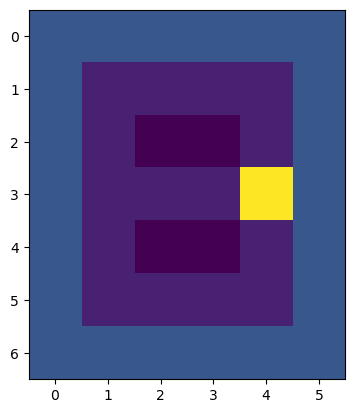

tensor(2, device='cuda:0')


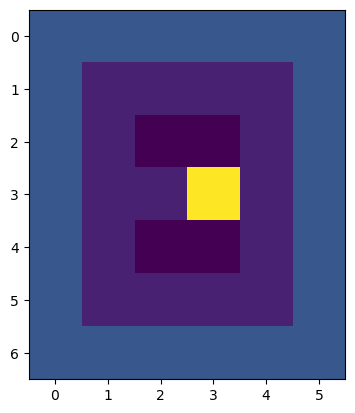

tensor(2, device='cuda:0')


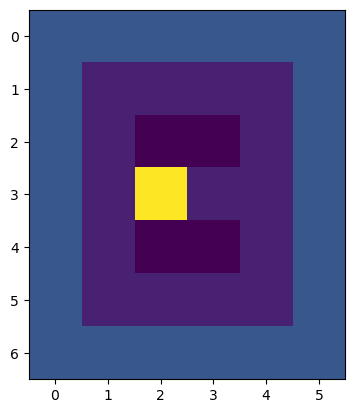

tensor(2, device='cuda:0')


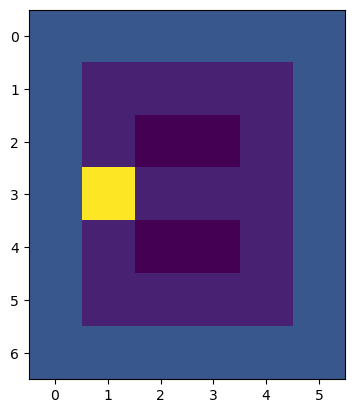

tensor(1, device='cuda:0')


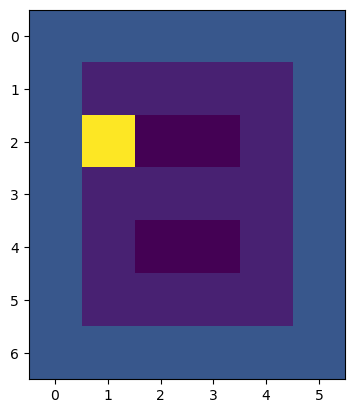

tensor(1, device='cuda:0')


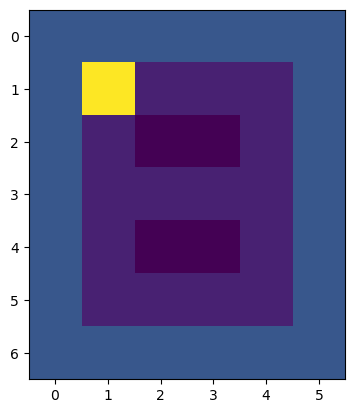

tensor(0, device='cuda:0')


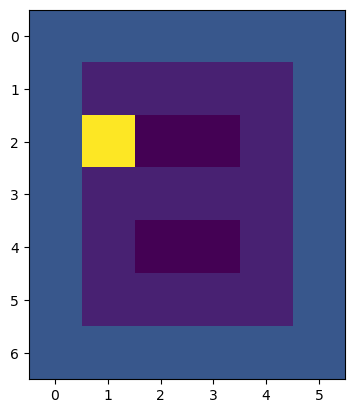

tensor(0, device='cuda:0')


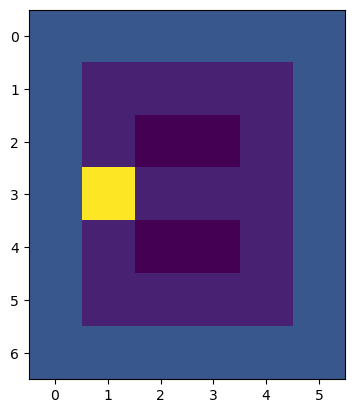

tensor(0, device='cuda:0')


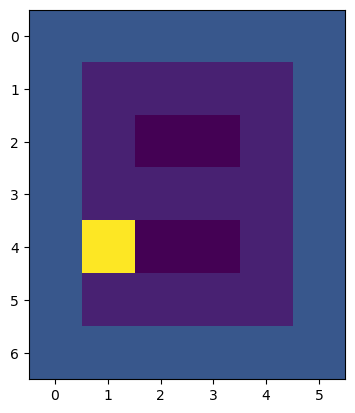

tensor(0, device='cuda:0')


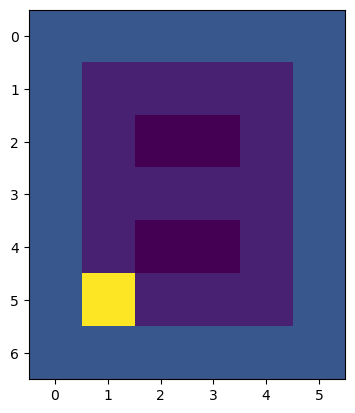

tensor(3, device='cuda:0')


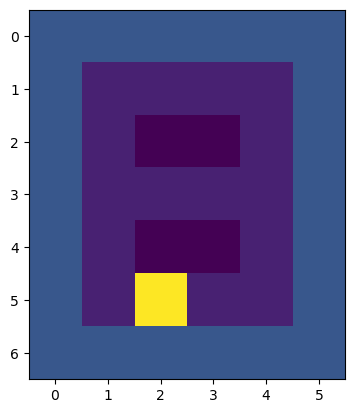

tensor(3, device='cuda:0')


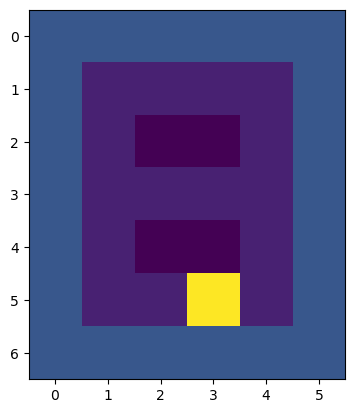

tensor(3, device='cuda:0')


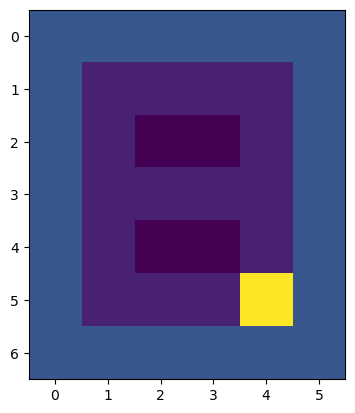

tensor(1, device='cuda:0')


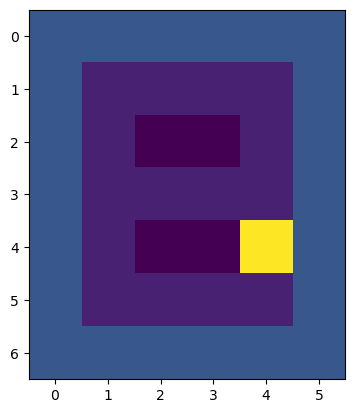

tensor(1, device='cuda:0')


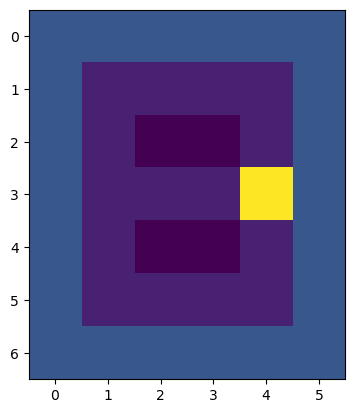

tensor(2, device='cuda:0')


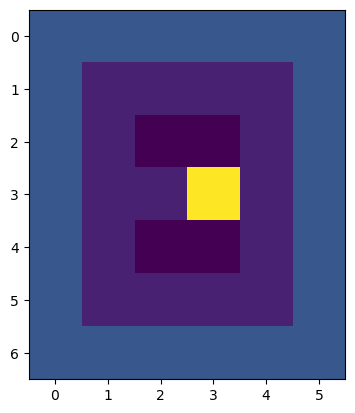

tensor(2, device='cuda:0')


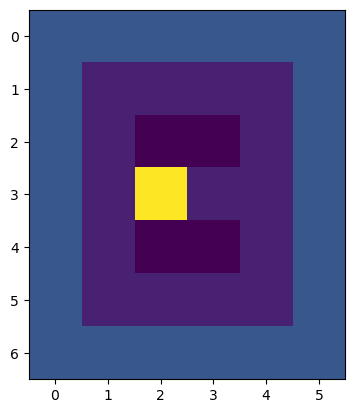

tensor(2, device='cuda:0')


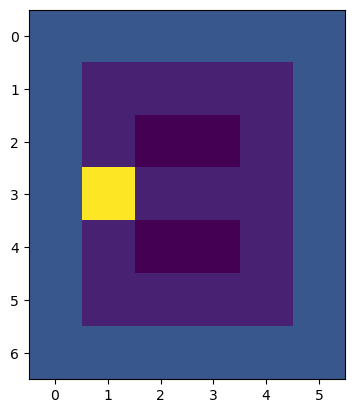

tensor(1, device='cuda:0')


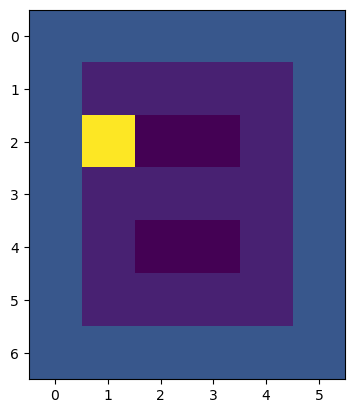

tensor(1, device='cuda:0')


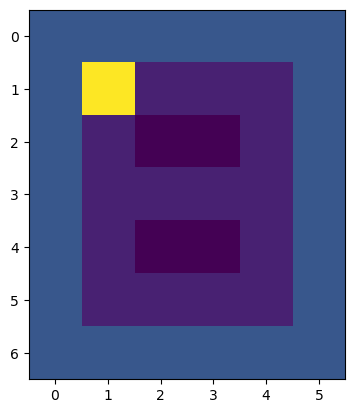

tensor(0, device='cuda:0')


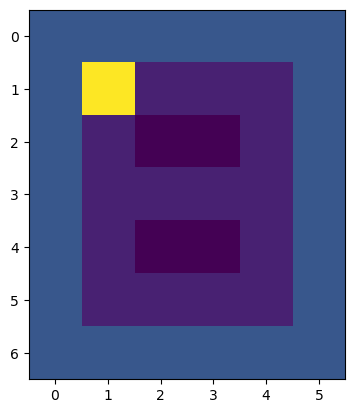

tensor(3, device='cuda:0')


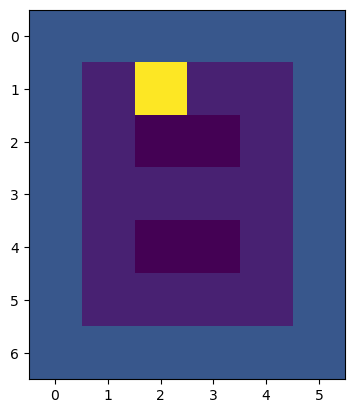

tensor(3, device='cuda:0')


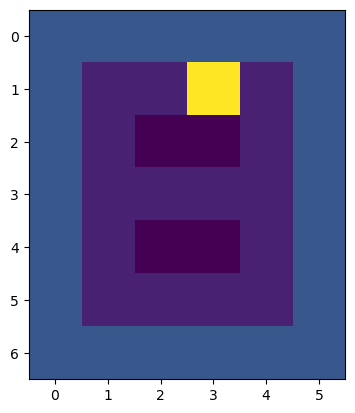

tensor(3, device='cuda:0')


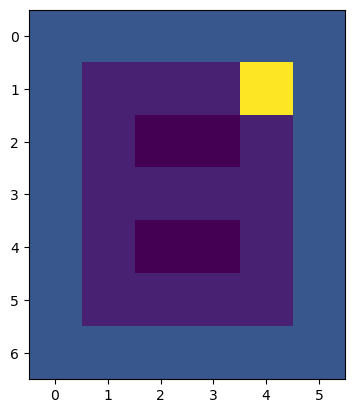

tensor(0, device='cuda:0')


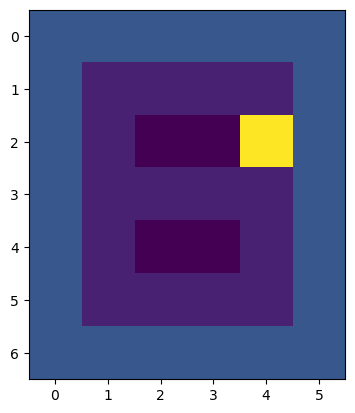

tensor(0, device='cuda:0')


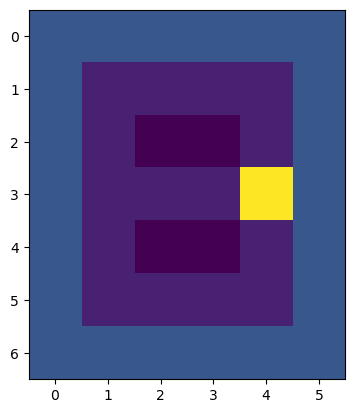

tensor(2, device='cuda:0')


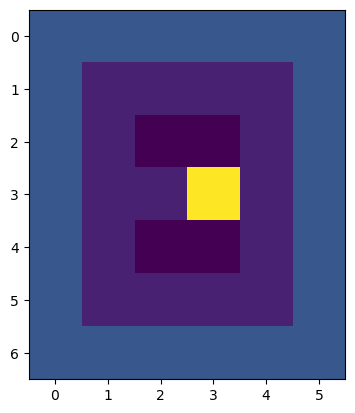

tensor(2, device='cuda:0')


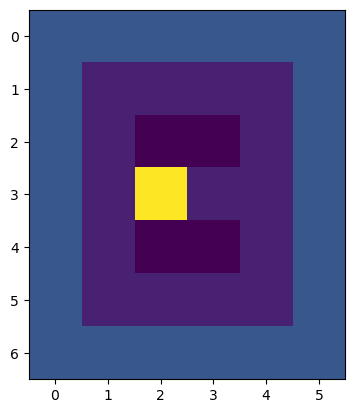

tensor(2, device='cuda:0')


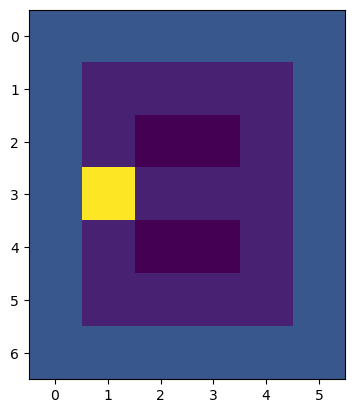

tensor(1, device='cuda:0')


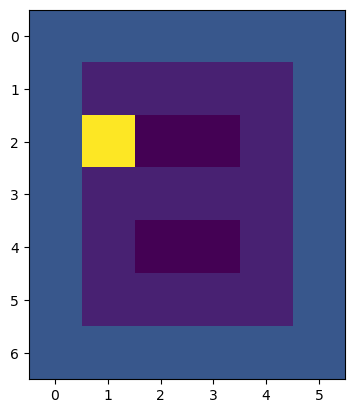

tensor(1, device='cuda:0')


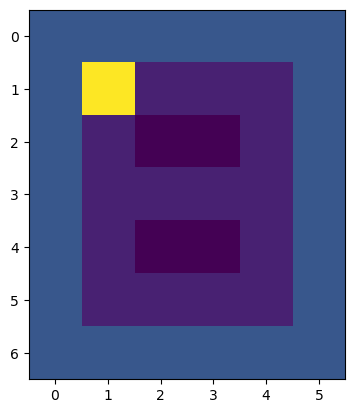

tensor(0, device='cuda:0')


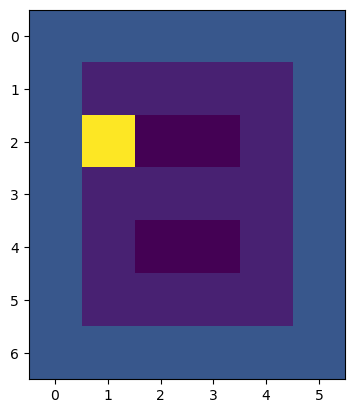

tensor(0, device='cuda:0')


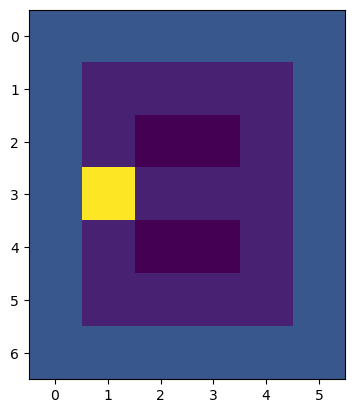

tensor(0, device='cuda:0')


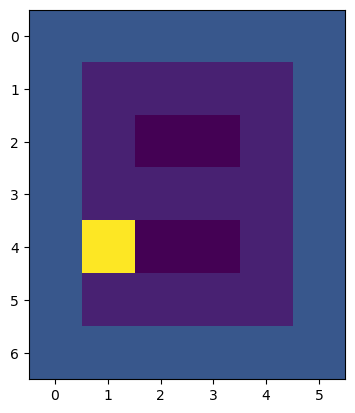

tensor(0, device='cuda:0')


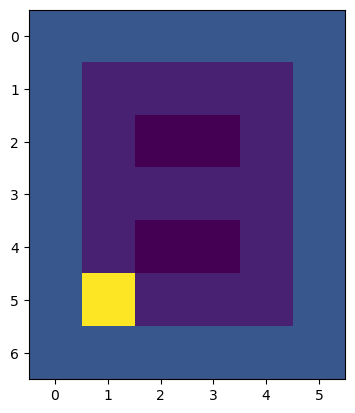

tensor(3, device='cuda:0')


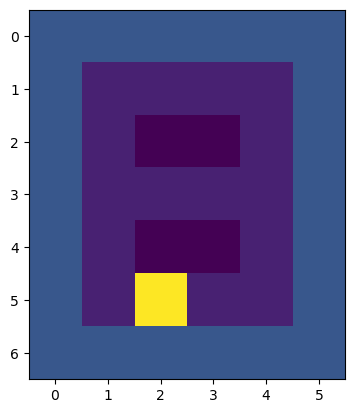

tensor(3, device='cuda:0')


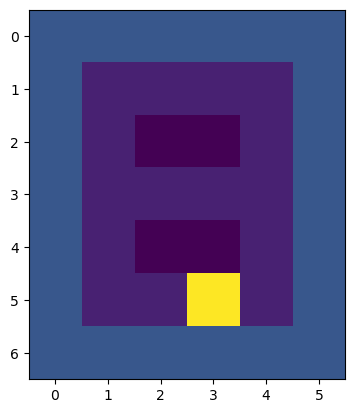

tensor(3, device='cuda:0')


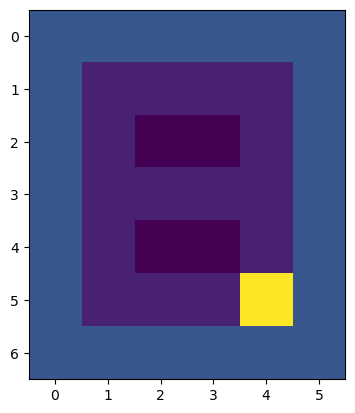

tensor(1, device='cuda:0')


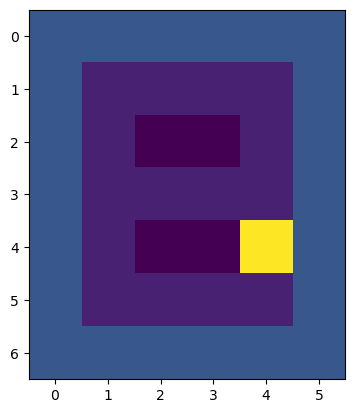

tensor(1, device='cuda:0')


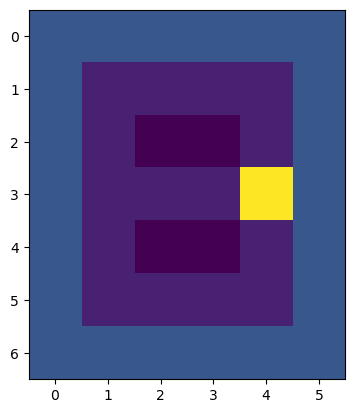

tensor(2, device='cuda:0')


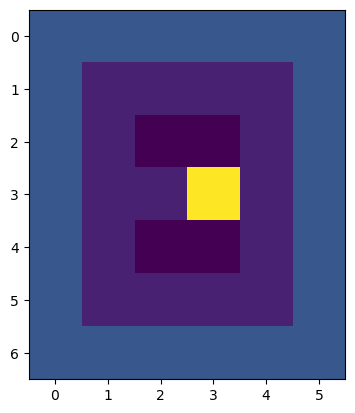

tensor(2, device='cuda:0')


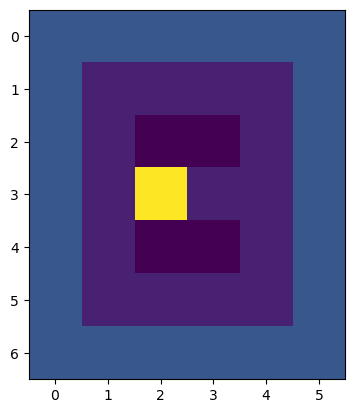

tensor(2, device='cuda:0')


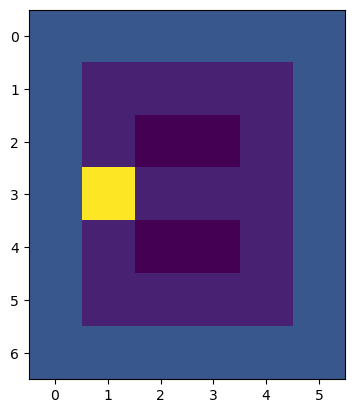

tensor(1, device='cuda:0')


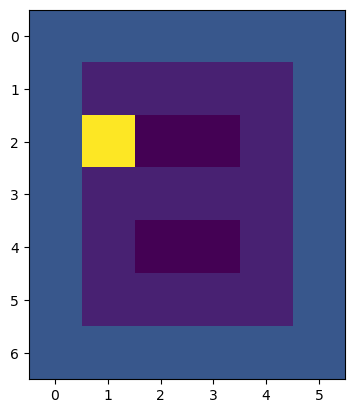

tensor(1, device='cuda:0')


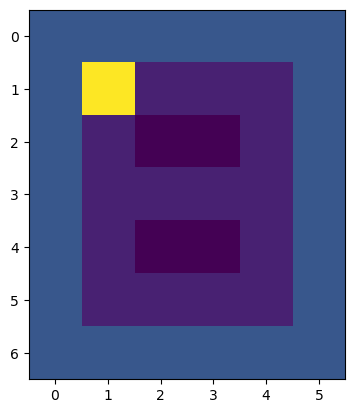

tensor(0, device='cuda:0')


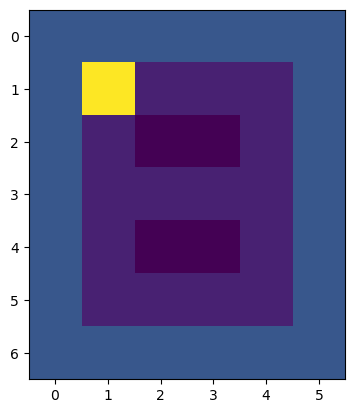

tensor(3, device='cuda:0')


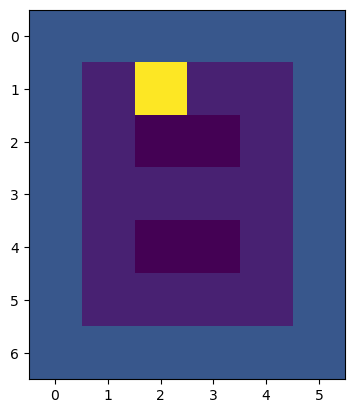

tensor(3, device='cuda:0')


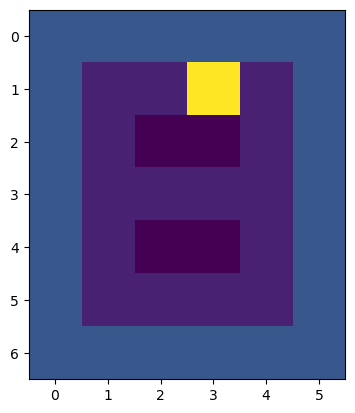

tensor(3, device='cuda:0')


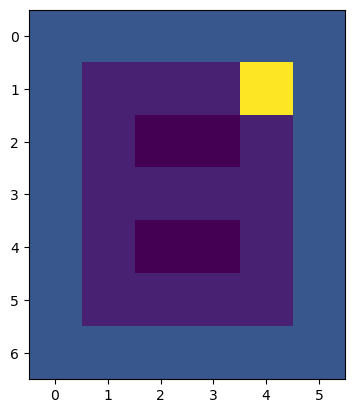

tensor(0, device='cuda:0')


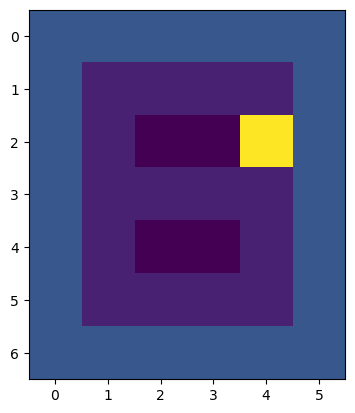

tensor(0, device='cuda:0')


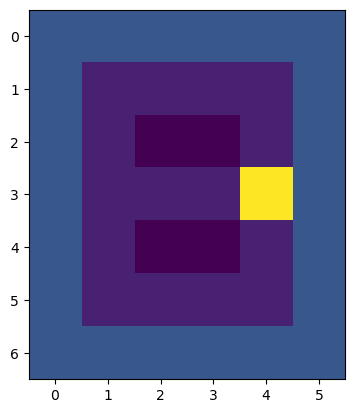

tensor(2, device='cuda:0')


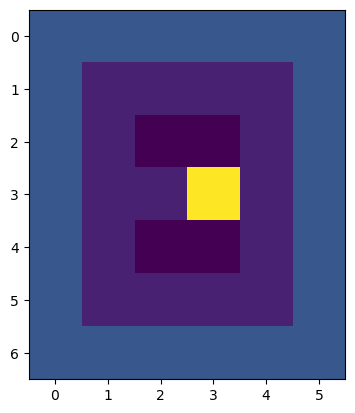

tensor(2, device='cuda:0')


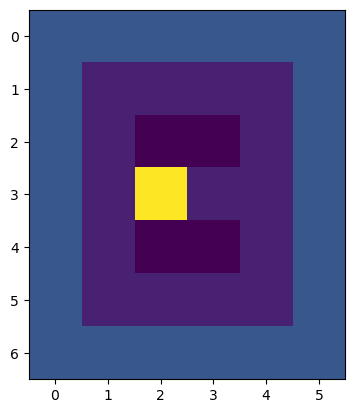

tensor(2, device='cuda:0')


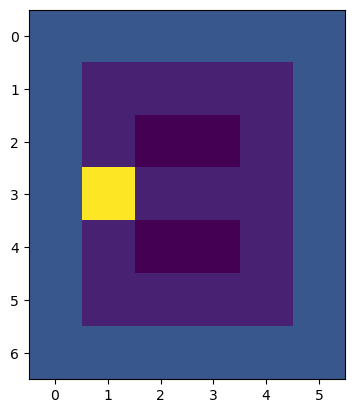

tensor(1, device='cuda:0')


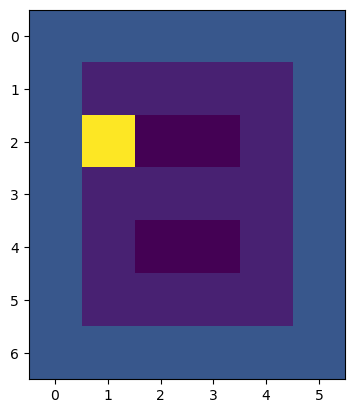

tensor(1, device='cuda:0')


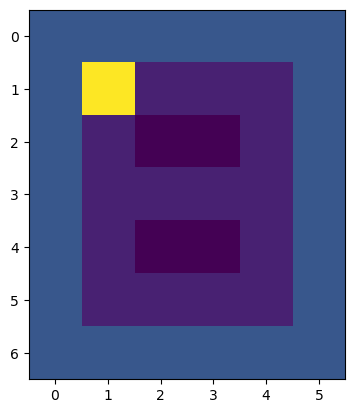

tensor(0, device='cuda:0')


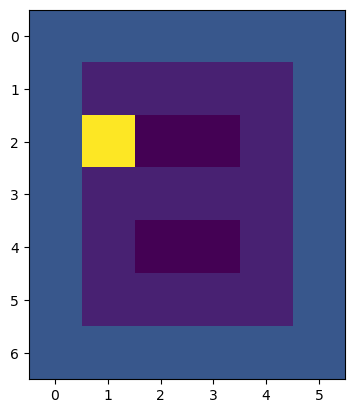

tensor(0, device='cuda:0')


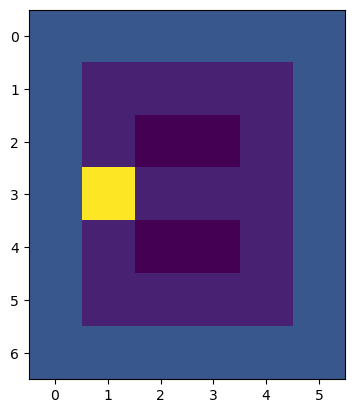

tensor(0, device='cuda:0')


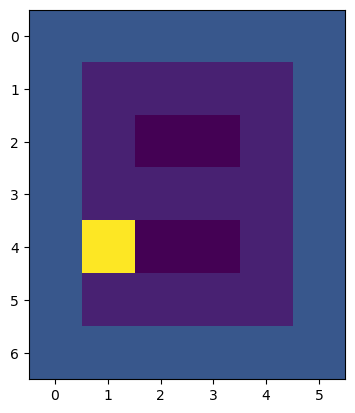

tensor(0, device='cuda:0')


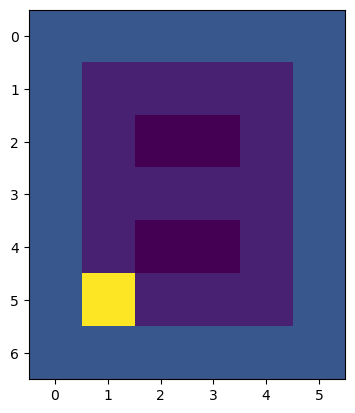

tensor(3, device='cuda:0')


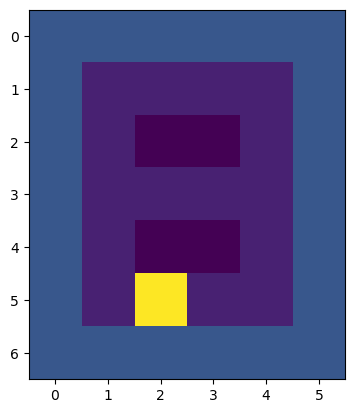

tensor(3, device='cuda:0')


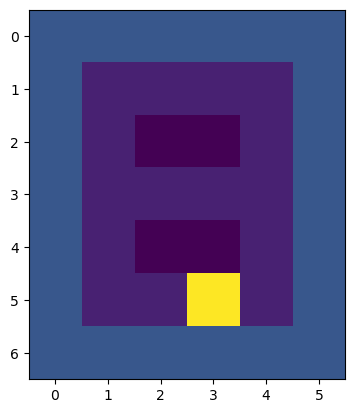

tensor(3, device='cuda:0')


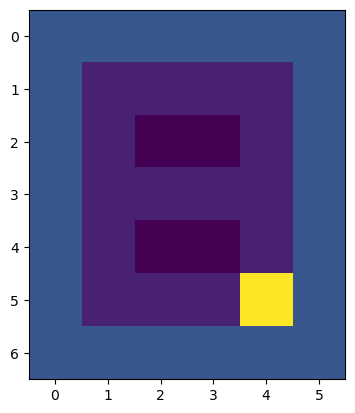

tensor(1, device='cuda:0')


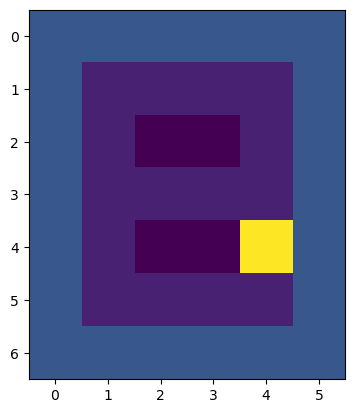

tensor(1, device='cuda:0')


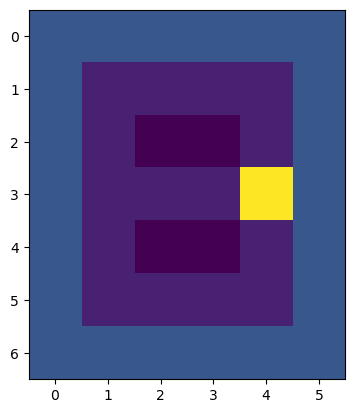

tensor(2, device='cuda:0')


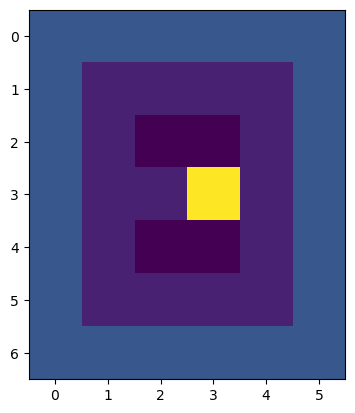

tensor(2, device='cuda:0')


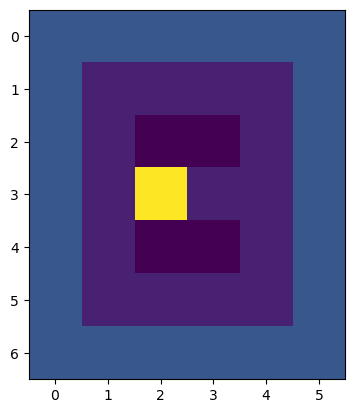

tensor(2, device='cuda:0')


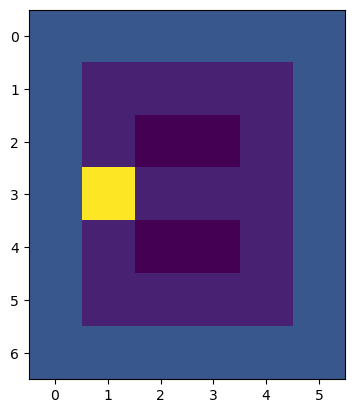

tensor(1, device='cuda:0')


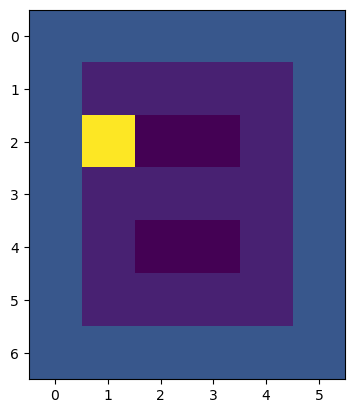

tensor(1, device='cuda:0')


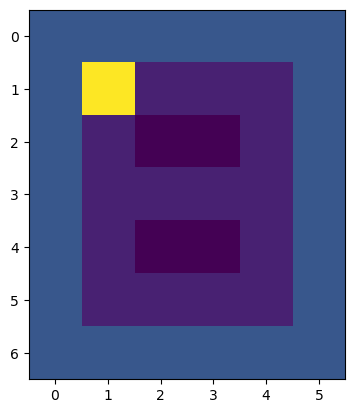

tensor(0, device='cuda:0')


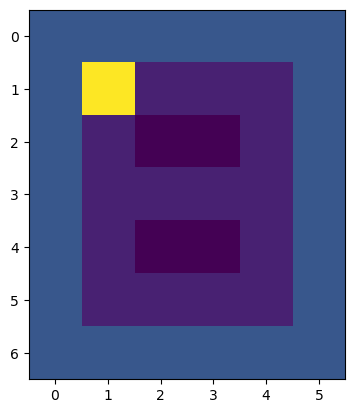

tensor(3, device='cuda:0')


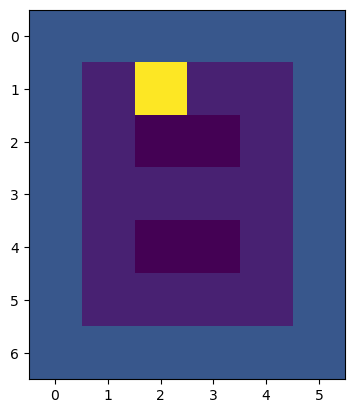

tensor(3, device='cuda:0')


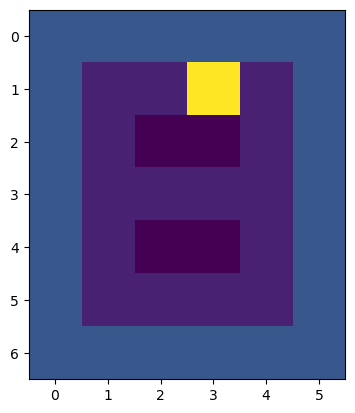

tensor(3, device='cuda:0')


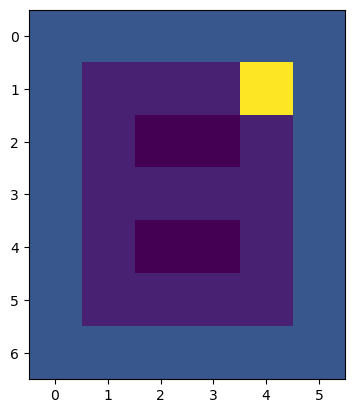

tensor(0, device='cuda:0')


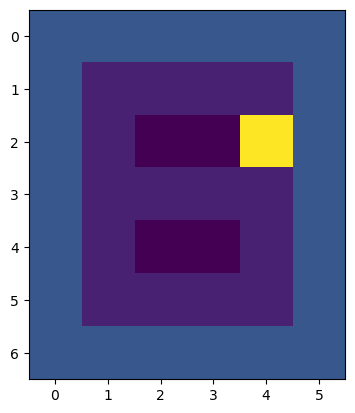

tensor(0, device='cuda:0')


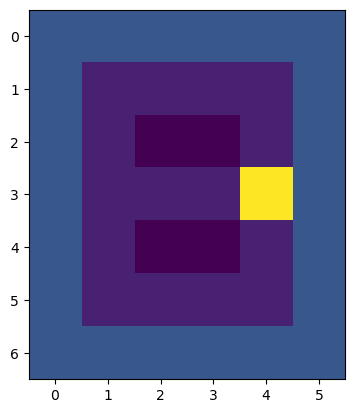

tensor(2, device='cuda:0')


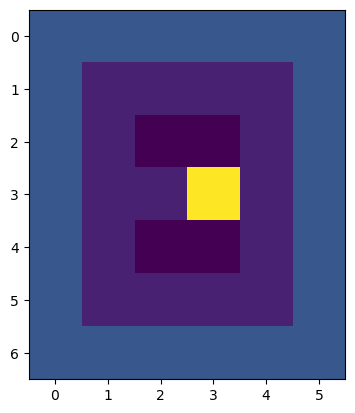

tensor(2, device='cuda:0')


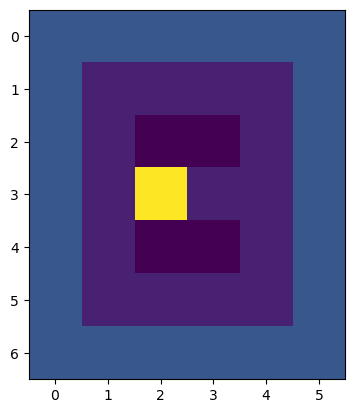

tensor(2, device='cuda:0')


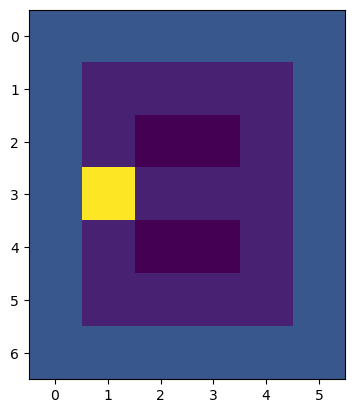

tensor(1, device='cuda:0')


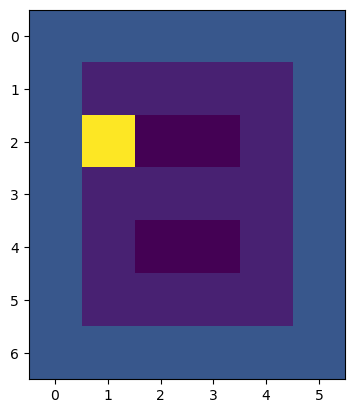

tensor(1, device='cuda:0')


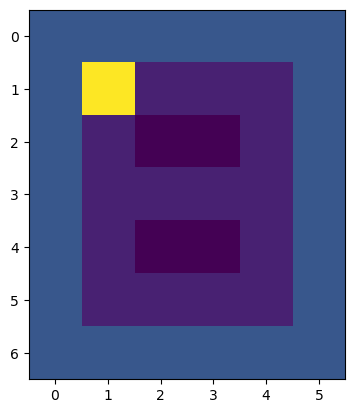

tensor(0, device='cuda:0')


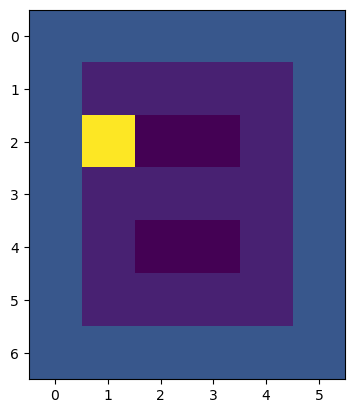

tensor(0, device='cuda:0')


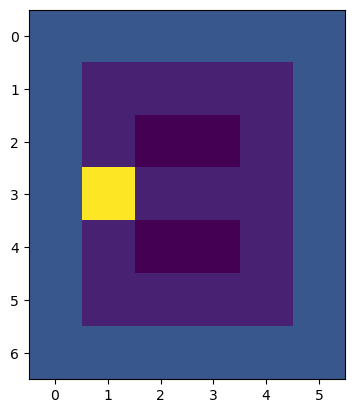

tensor(0, device='cuda:0')


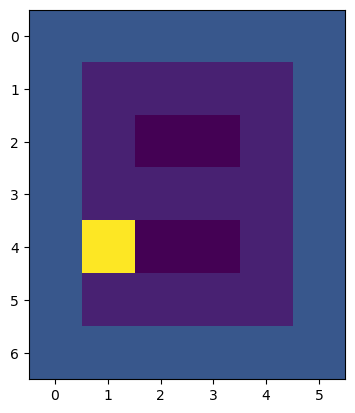

tensor(0, device='cuda:0')


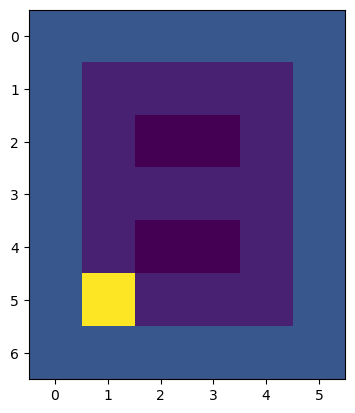

tensor(3, device='cuda:0')


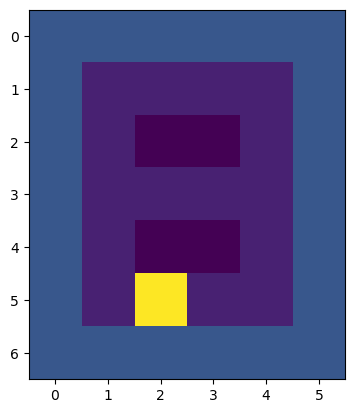

tensor(3, device='cuda:0')


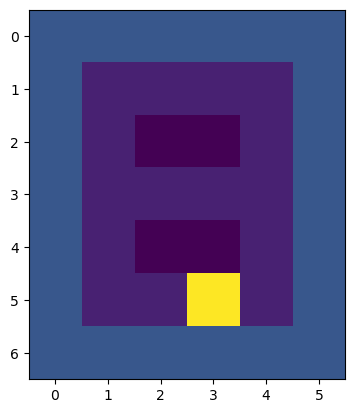

tensor(3, device='cuda:0')


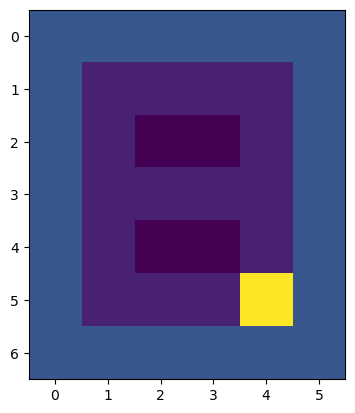

tensor(1, device='cuda:0')


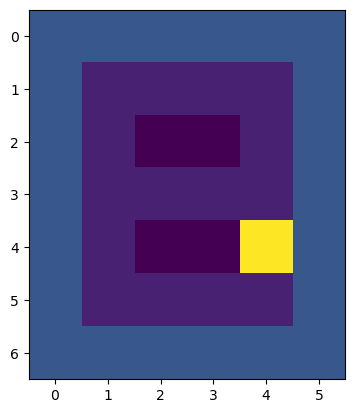

tensor(1, device='cuda:0')


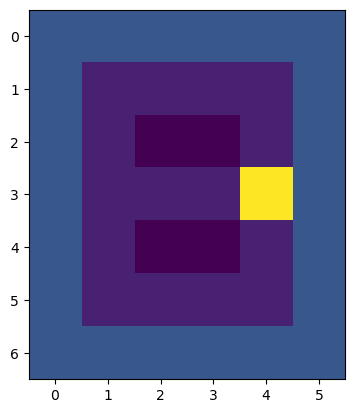

tensor(2, device='cuda:0')


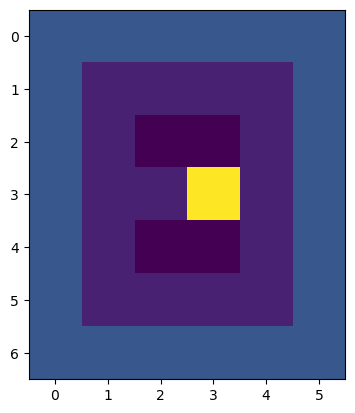

tensor(2, device='cuda:0')


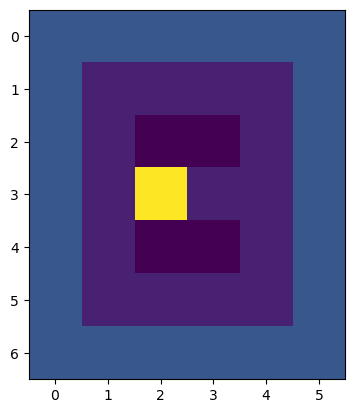

tensor(2, device='cuda:0')


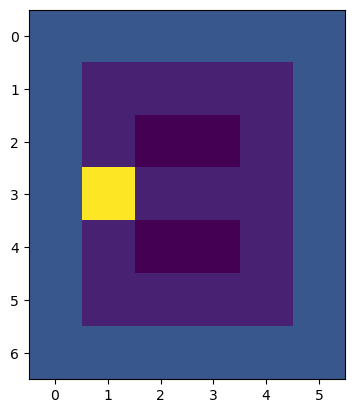

tensor(1, device='cuda:0')


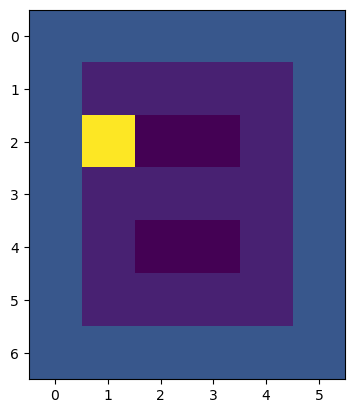

tensor(1, device='cuda:0')


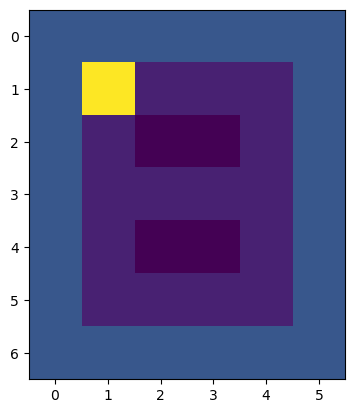

tensor(0, device='cuda:0')


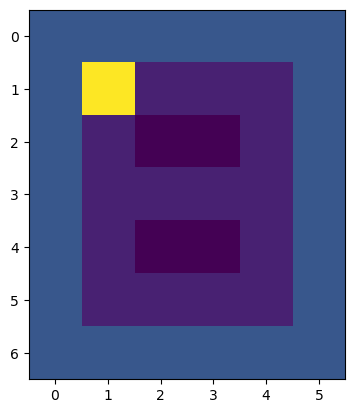

tensor(3, device='cuda:0')


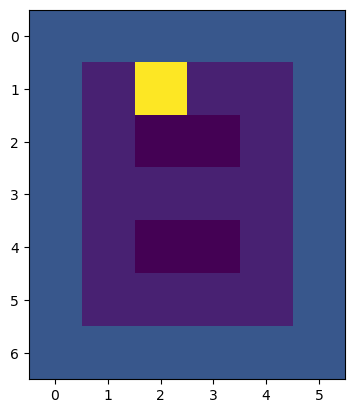

tensor(3, device='cuda:0')


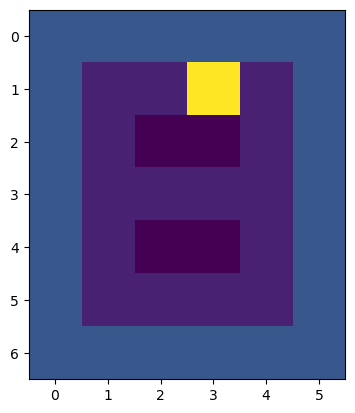

tensor(3, device='cuda:0')


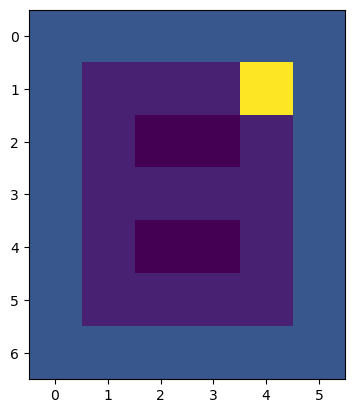

tensor(0, device='cuda:0')


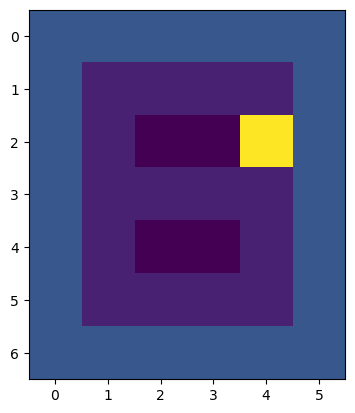

tensor(0, device='cuda:0')


In [27]:
%matplotlib inline

for i in range(100):
    obs = env.observe()
    _obs = obs[0].reshape((env.WIDTH+2, env.HEIGHT+2))
    plt.figure()
    plt.imshow(np.flip(_obs.squeeze()))
    plt.show()
    for i in range(len(obs)):
        agent._state[i][0:-1] = agent._state[i][1:]
        agent._state[i][-1] = obs[i]
    V, action, reward = agent._step()
    print(action)
    print()
    agent._Vs_on_last_episode.append(V)
    is_terminal = env.inTerminalState()
    if is_terminal: break

### As animation

In [ ]:
%matplotlib notebook

import numpy as np 
import matplotlib.pyplot as plt
from IPython.display import HTML
import matplotlib.animation as animation

fig, ax = plt.subplots(1,1)
obs = env.observe()
_obs = obs[0].reshape((env.WIDTH, env.HEIGHT))
_obs = np.flip(_obs.squeeze())
ax.set_xticks([])
ax.set_yticks([])
im = ax.imshow(np.zeros(_obs.shape))

def init():
    plt.cla()
    im = ax.imshow(_obs)
    return [im]

def animate(i, *args, **kwargs):
    plt.cla()
    obs = env.observe()
    _obs = obs[0].reshape((env.WIDTH, env.HEIGHT))
    _obs = np.flip(_obs.squeeze())
    im = ax.imshow(_obs)
    for i in range(len(obs)):
        agent._state[i][0:-1] = agent._state[i][1:]
        agent._state[i][-1] = obs[i]
        V, action, reward, _ = agent._step()
        agent._Vs_on_last_episode.append(V)
    return [im]

ani = animation.FuncAnimation(fig, animate, init_func=init, 
     frames=100, blit=False, repeat=True)
ani.save(f'figs/{fname}/behavior.gif', writer="ffmpeg", fps = 15)
fig.show()